In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import os
import sys
sys.path.append('../')
sys.path.append('../../../')
sys.path.append('../../../external_lib/Chexpert/')
sys.path.append('../../../external_lib/pytorch-grad-cam')

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from model import DRModel

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
from einops import rearrange, reduce, repeat

from data.dataset import ImageDataset

from PIL import Image

import pandas as pd

In [2]:
# 查看torch版本
torch.__version__

'1.8.0'

In [3]:
# 查看表头信息
df = pd.read_csv('/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/train.csv')
df.columns

print('class 0:\t', df.columns[7])
print('class 1:\t', df.columns[10])
print('class 2:\t', df.columns[11])
print('class 3:\t', df.columns[13])
print('class 4:\t', df.columns[15])

class 0:	 Cardiomegaly
class 1:	 Edema
class 2:	 Consolidation
class 3:	 Atelectasis
class 4:	 Pleural Effusion


In [13]:
pretrained_file = '../checkpoints/epoch_0_0.8077.pth'
num_classes = 5
dr_model = DRModel(num_classes)
state_dict = torch.load(pretrained_file, map_location='cpu')
# dr_model.load_state_dict(state_dict, strict=False)
dr_model.load_state_dict(state_dict)

infile = '/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/valid/patient64609/study1/view1_frontal.jpg'
image = ImageDataset.aug(infile)
imagexx = image.unsqueeze(0)
dr_model.eval()
probs = dr_model(imagexx)
print(probs)
dr_model.cuda()
probs = dr_model(imagexx.cuda())
print(probs)

target_layer = dr_model.features[7][-1]
cam = GradCAM(model=dr_model, target_layer=target_layer, use_cuda=True)

tensor([[0.0993, 0.7991, 0.1888, 0.4541, 0.5404]], grad_fn=<SigmoidBackward>)
tensor([[0.0993, 0.7991, 0.1888, 0.4541, 0.5404]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


In [5]:
# dr_model.features[7][-1]

In [14]:
image_file = '/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/valid/patient64609/study1/view1_frontal.jpg'

# # PIL image
# image = Image.open(image_file)
cv_img = cv2.imread(image_file)
cv_img = cv2.resize(cv_img, (512,512))
# print(image)

image = ImageDataset.aug(image_file)
input_tensor = image.unsqueeze(0).cuda()
# image = ImageDataset.aug(image_file)
# image = image.numpy()
# image = np.expand_dims(image, 0)
# print(image.shape)
# input_tensor = torch.from_numpy(image).cuda()


# from easydict import EasyDict as edict
# import json
# from torch.utils.data import DataLoader

# root = os.path.abspath(os.path.join('../../../'))
# print(root)
# cfg_path = os.path.join(root, 'external_lib/Chexpert/config/lse_fpa.json')
# with open(cfg_path) as f:
#     cfg = edict(json.load(f))
# val_label_path = '/data/medical/external/xray/CheXpert/CheXpert-v1.0-small/valid.csv'
# val_ds = ImageDataset(val_label_path, cfg, mode='val')
# val_data_loader = DataLoader(val_ds, batch_size=2, num_workers=8, shuffle=True, pin_memory=False)
# index = val_ds._image_paths.index(image_file)
# image, labels, filename = val_ds.__getitem__(index)
# input_tensor = image.unsqueeze(0)

In [19]:
# grayscale_cam = cam(input_tensor=input_tensor, target_category=2)

# rgb_img = np.array(cv_img, np.float32)/255
# visualization = show_cam_on_image(rgb_img, grayscale_cam)

# plt.figure()
# plt.imshow(grayscale_cam)
# plt.figure()
# plt.imshow(visualization)

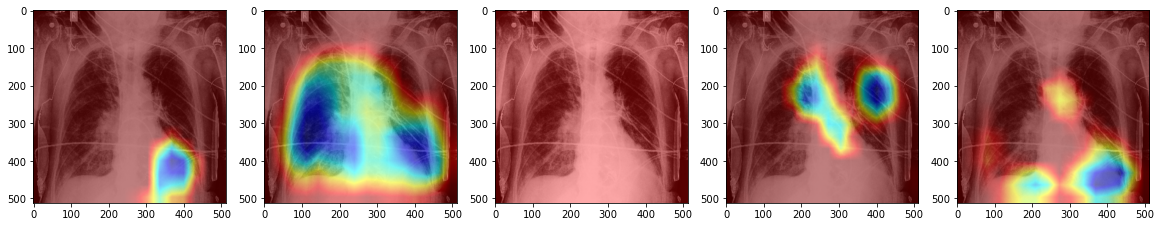

In [20]:
plt.figure(figsize=(20,10))
for num in range(num_classes):
    grayscale_cam = cam(input_tensor=input_tensor, target_category=num)
    rgb_img = np.array(cv_img, np.float32)/255
    visualization = show_cam_on_image(rgb_img, grayscale_cam)
    
    plt.subplot(1,num_classes,num+1)
    plt.imshow(visualization)

In [17]:
probs = dr_model(imagexx.cuda())
print(probs)

tensor([[0.0993, 0.7991, 0.1888, 0.4541, 0.5404]], device='cuda:0',
       grad_fn=<SigmoidBackward>)


In [18]:
class_names = ['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural_Effusion']
for i in range(num_classes):
    print('{} probability:\t{:.4f}'.format(class_names[i], probs.detach().cpu().numpy()[0][i]))
print(probs)

Cardiomegaly probability:	0.0993
Edema probability:	0.7991
Consolidation probability:	0.1888
Atelectasis probability:	0.4541
Pleural_Effusion probability:	0.5404
tensor([[0.0993, 0.7991, 0.1888, 0.4541, 0.5404]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
